In [1]:
# %load ../load_magic/storage.py

!mkdir ../data
!mkdir ../data/csv
!mkdir ../saves
!mkdir ../saves/pickle
!mkdir ../saves/csv
import pickle
import pandas as pd
import os

# Handy list of the different types of encodings
encoding = ['latin1', 'iso8859-1', 'utf-8'][2]

# Change this to your data and saves folders
data_folder = r'../data/'
saves_folder = r'../saves/'

def load_csv(csv_name=None, folder_path=None):
    if folder_path is None:
        csv_folder = data_folder + 'csv/'
    else:
        csv_folder = folder_path + 'csv/'
    if csv_name is None:
        csv_path = max([os.path.join(csv_folder, f) for f in os.listdir(csv_folder)],
                       key=os.path.getmtime)
    else:
        csv_path = csv_folder + csv_name + '.csv'
    data_frame = pd.read_csv(csv_path, encoding=encoding)
    
    return(data_frame)

def load_dataframes(**kwargs):
    frame_dict = {}
    for frame_name in kwargs:
        pickle_path = saves_folder + 'pickle/' + frame_name + '.pickle'
        if not os.path.isfile(pickle_path):
            csv_folder = saves_folder + 'csv/'
            csv_path = csv_folder + frame_name + '.csv'
            if not os.path.isfile(csv_path):
                csv_path = data_folder + 'csv/' + frame_name + '.csv'
                if not os.path.isfile(csv_path):
                    frame_dict[frame_name] = None
                else:
                    frame_dict[frame_name] = load_csv(csv_name=frame_name)
            else:
                frame_dict[frame_name] = load_csv(csv_name=frame_name, folder_path=csv_folder)
        else:
            frame_dict[frame_name] = load_object(frame_name)

def load_object(obj_name):
    pickle_path = saves_folder + 'pickle/' + obj_name + '.pickle'
    try:
        object = pd.read_pickle(pickle_path)
    except:
        with open(pickle_path, 'rb') as handle:
            object = pickle.load(handle)
    
    return(object)

def save_dataframes(include_index=False, **kwargs):
    csv_folder = saves_folder + 'csv/'
    for frame_name in kwargs:
        if isinstance(kwargs[frame_name], pd.DataFrame):
            csv_path = csv_folder + frame_name + '.csv'
            kwargs[frame_name].to_csv(csv_path, sep=',', encoding=encoding,
                                      index=include_index)

# Classes, functions, and methods cannot be pickled
def store_objects(**kwargs):
    for obj_name in kwargs:
        if hasattr(kwargs[obj_name], '__call__'):
            raise RuntimeError('Functions cannot be pickled.')
        obj_path = saves_folder + 'pickle/' + str(obj_name)
        pickle_path = obj_path + '.pickle'
        if isinstance(kwargs[obj_name], pd.DataFrame):
            kwargs[obj_name].to_pickle(pickle_path)
        else:
            with open(pickle_path, 'wb') as handle:
                pickle.dump(kwargs[obj_name], handle, pickle.HIGHEST_PROTOCOL)

mkdir: ../data: File exists
mkdir: ../data/csv: File exists
mkdir: ../saves: File exists
mkdir: ../saves/pickle: File exists
mkdir: ../saves/csv: File exists


In [4]:

# Download CoinBase prices
from urllib.request import urlretrieve
from gzip import GzipFile
import os
import numpy as np
from datetime import datetime

# http://api.bitcoincharts.com/v1/csv/
def get_price_data(price_history_name, price_history_url, column_list):
    frame_name = str(price_history_name) + '_df'
    pickle_path = saves_folder + 'pickle/' + frame_name + '.pickle'
    if not os.path.isfile(pickle_path):
        
        csv_path = saves_folder + 'csv/' + frame_name + '.csv'
        if not os.path.isfile(csv_path):

            out_file_path = data_folder + 'csv/' + str(price_history_name) + '.csv'
            if not os.path.isfile(out_file_path):
                local_filename, headers = urlretrieve(price_history_url)
                with gzip.open(local_filename, 'rb') as f:
                    price_history_decompressed = f.read()
                with open(out_file_path, 'w') as output:
                    size = output.write(price_history_decompressed.decode())

            price_history_df = pd.read_csv(out_file_path, encoding=encoding, header=None)

            price_history_df.columns = column_list
            if 'time_stamp' in column_list:
                price_history_df['date'] = price_history_df['time_stamp'].map(lambda x: pd.to_datetime(x, unit='s'))
            else:
                price_history_df['date'] = price_history_df['date'].map(lambda x: datetime.strptime(str(x).strip(), '%x'))
            price_history_df['year'] = price_history_df['date'].map(lambda x: x.year)
            price_history_df['month'] = price_history_df['date'].map(lambda x: x.month)
            price_history_df['day'] = price_history_df['date'].map(lambda x: x.day)
            price_history_df['week_day'] = price_history_df['date'].map(lambda x: x.weekday())
            price_history_df['log_price'] = price_history_df['price'].map(lambda x: np.log(x))
            price_history_df['log_diff'] = price_history_df.sort_values('date')['price'].diff()

            match_series = (price_history_df['log_price'] <= 0)
            price_history_df = price_history_df[~match_series]
            
            try:
                price_history_df.to_pickle(pickle_path)
            except Exception as e:
                print(e, ': Couldn\'t save ' + str(price_history_df.shape[0]*price_history_df.shape[1]) + ' cells as a pickle. Now saving as a csv.')
                price_history_df.to_csv(csv_path, sep=',', encoding=encoding, index=False)
                
        else:
            price_history_df = load_csv(frame_name, folder_path=saves_folder)
            price_history_df['date'] = price_history_df['date'].map(lambda x: pd.to_datetime(x))
            try:
                price_history_df.to_pickle(pickle_path)
            except Exception as e:
                print(e, ': Couldn\'t save ' + str(price_history_df.shape[0]*price_history_df.shape[1]) + ' cells as a pickle.')

    else:
        price_history_df = load_object(frame_name)
    
    return price_history_df

In [3]:

# Validates with https://en.wikipedia.org/wiki/History_of_bitcoin
price_history_url = 'http://api.bitcoincharts.com/v1/csv/coinbaseUSD.csv.gz'
column_list = ['time_stamp', 'price', 'idono']
coinbaseUSD_df = get_price_data('coinbaseUSD', price_history_url, column_list)
coinbaseUSD_df.head()

../saves/csv/coinbaseUSD_df.csv
[Errno 22] Invalid argument : Now saving as a csv.


,time_stamp,price,idono,date,year,month,day,week_day,log_price,log_diff
0,1417412036,300.0,0.010000,2014-12-01 05:33:56,2014,12,1,0,5.703782,NaN
1,1417412423,300.0,0.010000,2014-12-01 05:40:23,2014,12,1,0,5.703782,0.0
2,1417415048,370.0,0.010000,2014-12-01 06:24:08,2014,12,1,0,5.913503,70.0
3,1417416612,370.0,0.026556,2014-12-01 06:50:12,2014,12,1,0,5.913503,0.0
4,1417498166,377.0,0.010000,2014-12-02 05:29:26,2014,12,2,1,5.932245,7.0


In [6]:

coinbaseUSD_df.loc[coinbaseUSD_df.shape[0]-1]

time_stamp             1512614121
price                     13968.7
idono                    0.141945
date          2017-12-07 02:35:21
year                         2017
month                          12
day                             7
week_day                        3
log_price                 9.54458
log_diff                    -1.22
Name: 26285808, dtype: object


## Buying Digital Currency

Fees are added to the amount entered to arrive at the total for the order. For example, if you enter \$100 USD as the amount of BTC to buy, and the fee is 1.49%, your total will be \$101.49. That total will be charged to your payment method and you will receive \$100 worth of BTC.

In [7]:

coinbaseUSD_df['date'].dtype

dtype('<M8[ns]')

In [8]:

groupby_list = ['year', 'month', 'day']
monday_price_df = coinbaseUSD_df.groupby(groupby_list,
                                         as_index=False).apply(lambda x: x.loc[[x.date.idxmax()]]).copy()
match_series = (monday_price_df['week_day'] == 0)
monday_price_df = monday_price_df[match_series].reset_index(drop=True)

In [9]:

from datetime import datetime
import pandas as pd

trading_fee = 0.0149
weekly_budget = 5.0
latest_price = coinbaseUSD_df.loc[coinbaseUSD_df.shape[0]-1]['price']
def total_saved(weekly_budget, format_result=True):
    weekly_amount = weekly_budget - weekly_budget*trading_fee
    column_list = ['date_time', 'shares_added']
    rows_list = []
    trading_date = datetime(monday_price_df.loc[0, 'year'].squeeze(),
                            monday_price_df.loc[0, 'month'].squeeze(),
                            monday_price_df.loc[0, 'day'].squeeze())
    for row_index, row_series in monday_price_df.iterrows():
        row_dict = {}
        row_dict['date_time'] = row_series['date']
        row_dict['shares_added'] = weekly_amount/row_series['price']
        rows_list.append(row_dict)

    weekly_amount_df = pd.DataFrame(rows_list, columns=column_list)
    total_amount = weekly_amount_df['shares_added'].sum()*latest_price
    if format_result:
        total_amount = '${:,.2f}'.format(total_amount)
    
    return total_amount

In [10]:

print(total_saved(10.))

$43,661.15


In [11]:

import statsmodels.formula.api as smf

# Use ols function for calculating the F-statistic and associated p value
price_history_ols = smf.ols(formula='log_price ~ time_stamp', data=coinbaseUSD_df)
price_history_fitted = price_history_ols.fit()
price_history_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                 2.443e+08
Date:                Sun, 10 Dec 2017   Prob (F-statistic):               0.00
Time:                        22:32:35   Log-Likelihood:            -1.1949e+07
No. Observations:            26285809   AIC:                         2.390e+07
Df Residuals:                26285807   BIC:                         2.390e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -55.1951      0.004  -1.38e+04      0.000     -55.203     -55.187
time_stamp  4.214e-08    2.7e-12   1.56e+04      0.000    4.21e-08    4.21e-08
==============================================================================
Omnibus:                  1145503.607   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           720583.634
Skew:                           0.277   Prob(JB):                         0.00
Kurtosis:                       2.407   Cond. No.                     7.93e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.93e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [12]:

params_series = price_history_fitted.params

def date_when(amount):
    time_stamp = (np.log(amount)-params_series.loc['Intercept'])/params_series.loc['time_stamp']
    date_time = pd.to_datetime(time_stamp, unit='s')
    
    return date_time.strftime('%Y-%m-%d')

In [13]:

date_when(110000)

'2020-03-25'

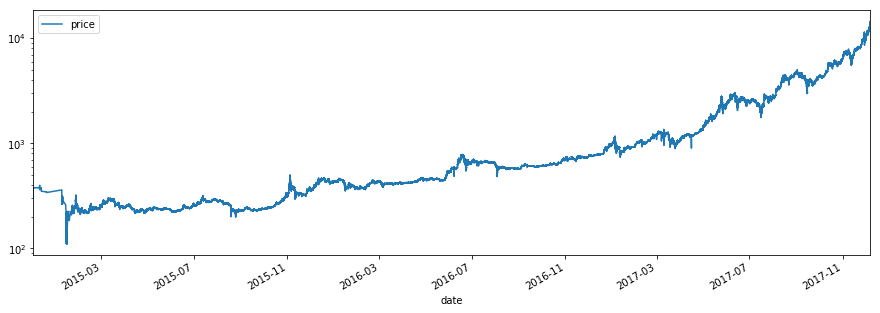

In [14]:

%matplotlib inline

axes_sub_plot = coinbaseUSD_df.plot(x='date', y='price', kind='line', figsize=(15, 5), logy=True)

In [15]:

# How do you add a second line to the plot?
axes_sub_plot.plot(x=coinbaseUSD_df['date'], y=np.exp(params_series.loc['Intercept']+coinbaseUSD_df['log_price']*params_series.loc['time_stamp']),
                   kind='line', figsize=(15, 5), logy=True)

[]

In [16]:

coinbaseUSD_df.loc[0, 'date']

Timestamp('2014-12-01 05:33:56')

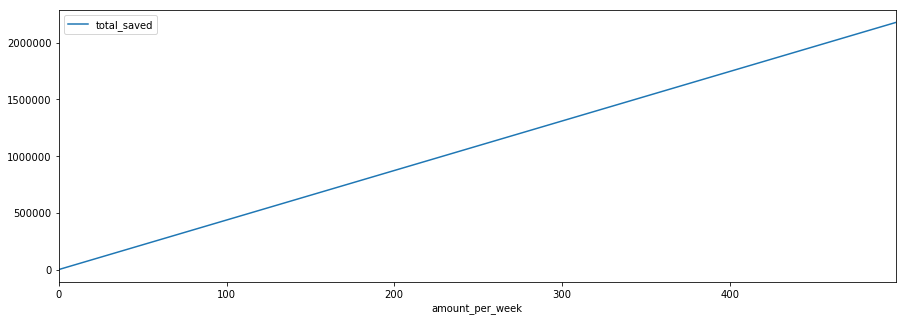

In [17]:

column_list = ['amount_per_week', 'total_saved']
amount_per_week = range(0, 500)
amount_saved = [total_saved(amount, format_result=False) for amount in amount_per_week]
rows_list = [dict(zip(column_list, [w, s])) for w, s in zip(amount_per_week, amount_saved)]
weekly_amount_df = pd.DataFrame(rows_list, columns=column_list)
axes_sub_plot = weekly_amount_df.plot(x='amount_per_week', y='total_saved', kind='line', figsize=(15, 5), logy=False)

In [18]:

price_history_url = None
column_list = ['date', 'close', 'volume', 'price', 'high', 'low']
WMT_df = get_price_data('WMT', price_history_url, column_list)
WMT_df.head()

,date,close,volume,price,high,low,year,month,day,week_day,log_price,log_diff
0,2017-12-07,96.78,7498316,97.06,97.58,96.6500,2017,12,7,3,4.575329,NaN
1,2017-12-06,97.28,7138716,97.99,98.14,97.2401,2017,12,6,2,4.584865,0.93
2,2017-12-05,97.83,9009041,97.00,97.94,96.9200,2017,12,5,1,4.574711,-0.99
3,2017-12-04,97.01,8954996,97.73,97.96,96.6750,2017,12,4,0,4.582209,0.73
4,2017-12-01,97.35,8295610,97.61,97.71,96.2300,2017,12,1,4,4.580980,-0.12


In [19]:

coinbaseUSD_df['log_diff'].std()

2.9770707105243166

In [20]:

match_series = (WMT_df['date'] < coinbaseUSD_df.loc[0, 'date'])
WMT_df[~match_series]['log_diff'].std()

0.8821374138179162

In [21]:

coinbaseUSD_df.shape

(26285809, 10)

In [25]:

SaP_df = pd.read_html(data_folder + 'html/S_and_P_500_by_month.html')[0]
SaP_df.columns = ['date', 'price']
SaP_df = SaP_df.reindex(SaP_df.index.drop(0))
SaP_df['date'] = SaP_df['date'].map(lambda x: pd.to_datetime(x.strip()))
match_series = (SaP_df['date'] < coinbaseUSD_df.loc[0, 'date'])
SaP_df = SaP_df[~match_series]
SaP_df['price'] = SaP_df['price'].map(lambda x: float(x))
SaP_df['year'] = SaP_df['date'].map(lambda x: x.year)
SaP_df['month'] = SaP_df['date'].map(lambda x: x.month)
SaP_df['day'] = SaP_df['date'].map(lambda x: x.day)
SaP_df['week_day'] = SaP_df['date'].map(lambda x: x.weekday())
SaP_df['log_price'] = SaP_df['price'].map(lambda x: np.log(x))
SaP_df['log_diff'] = SaP_df.sort_values('date')['price'].diff()
SaP_df.sort_values('log_diff', ascending=False).head()

,date,price,year,month,day,week_day,log_price,log_diff
21,2016-03-01,2021.95,2016,3,1,1,7.611818,117.53
12,2016-12-01,2246.63,2016,12,1,3,7.717187,81.64
26,2015-10-01,2024.81,2015,10,1,3,7.613231,80.40
17,2016-07-01,2148.90,2016,7,1,4,7.672711,65.01
1,2017-11-01,2579.36,2017,11,1,2,7.855297,58.16


In [26]:

# Why is the S&P 500 volatility so much greater than Coinbase?
match_series = (SaP_df['date'] < coinbaseUSD_df.loc[0, 'date'])
SaP_df[~match_series]['log_diff'].std()

49.38312217903735

In [27]:

# From https://www.investopedia.com/ask/answers/021015/what-best-measure-given-stocks-volatility.asp


When selecting a security for investment, traders look at its historical volatility to help determine the relative risk of a potential trade. There are numerous metrics that measure volatility in differing contexts, and each trader has favorites. Regardless of which metric you utilize, a firm understanding of the concept of volatility and how it is measured is essential to successful investing. Simply put, volatility is a reflection of the degree to which price moves. A stock with a price that fluctuates wildly, hits new highs and lows or moves erratically is considered highly volatile. A stock that maintains a relatively stable price has low volatility. A highly volatile stock is inherently riskier, but that risk cuts both ways. When investing in a volatile security, the risk of success is increased just as much as the risk of failure. For this reason, many traders with a high risk tolerance look to multiple measures of volatility to help inform their trade strategies.

The primary measure of volatility used by traders and analysts is standard deviation. This metric reflects the average amount a stock's price has differed from the mean over a period of time. It is calculated by determining the mean price for the established period and then subtracting this figure from each price point. The differences are then squared, summed and averaged to produce the variance. Because the variance is the product of squares, it is no longer in the original unit of measure. Since price is measured in dollars, a metric that uses dollars squared is not very easy to interpret. Therefore, standard deviation is calculated by taking the square root of the variance, which brings it back to the same unit of measure as the underlying data set.

Chartists use a technical indicator called Bollinger Bands to analyze standard deviation over time. Bollinger Bands are comprised of three lines: the simple moving average (SMA) and two bands placed one standard deviation above and below the SMA. The SMA is a moving average that changes with each session to incorporate that day's changes, and the outer bands mirror that change to reflect the corresponding adjustment to the standard deviation. Standard deviation is reflected by the width of the Bollinger Bands. The wider the Bollinger Bands, the more volatile a stock's price within the given period. A stock with low volatility has very narrow Bollinger Bands that sit close to the SMA.

For a more comprehensive assessment of risk, measure multiple forms of volatility. Where standard deviation measures a security's price movements compared to its average over time, beta measures a security's volatility relative to that of the wider market. A beta of 1 means the security has volatility that mirrors the degree and direction of the market as a whole. This means that if the S&P 500 takes a sharp dip, the stock in question is likely to follow suit. Relatively stable securities, such as utilities, have beta values of less than 1, reflecting their lower volatility. Stocks in rapidly changing fields, especially in the technology sector, have beta values of more than 1. A beta of 0 indicates the underlying security has no volatility. Cash is an excellent example, if no inflation is assumed.